# 📚 Amazon Book Reviews - Sentiment Analysis

Welcome to this professional-grade NLP project.  
This notebook performs sentiment analysis on Amazon book reviews using traditional NLP techniques.

---

### 🔍 Project Goals:
- Clean and preprocess review texts.
- Balance imbalanced sentiment classes.
- Vectorize reviews using TF-IDF.
- Train a Logistic Regression model to classify reviews as positive or negative.
- Evaluate performance with professional visualizations.

---


## 📦 1. Import Required Libraries

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## 📥 2. Load the Dataset

In [23]:
# Load the data
ratings_data = pd.read_csv('/kaggle/input/amazon-books-reviews/Books_rating.csv')

In [38]:
ratings_data.columns


Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text',
       'text_length'],
      dtype='object')

## 📊 3. Exploratory Visual Analysis (Sample-based)

To gain a quick understanding of the dataset, we performed visual exploration on a random sample of 3000 reviews to ensure speed and clarity.

The goal is to answer key analytical questions:

- **What is the overall distribution of review scores?**
  → Most reviews are 5 stars, indicating strong positive bias.

- **How long are typical reviews?**
  → The majority are short, though some exceed several thousand characters.

- **Which words appear most frequently?**
  → Common terms like "book", "story", and "read" dominate, showing natural patterns around literary content.

- **What products get the most attention?**
  → Highly popular books like *Pride and Prejudice* and *The Hobbit* lead in review count.

These insights guide preprocessing decisions and highlight dataset characteristics before modeling.


In [31]:
sample_data = ratings_data.sample(n=3000, random_state=42)


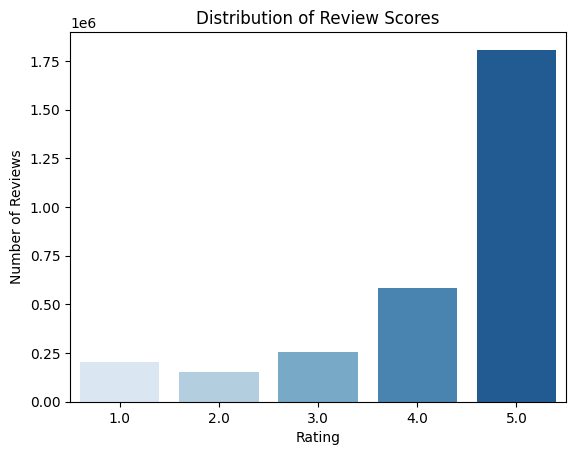

In [41]:
sns.countplot(x='review/score', data=ratings_data, palette='Blues')
plt.title('Distribution of Review Scores')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


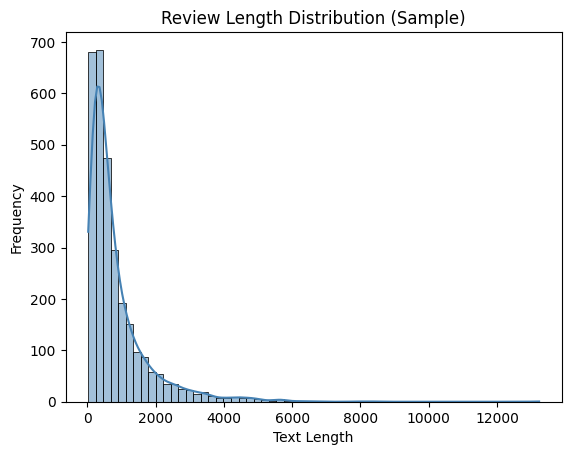

In [43]:
sample_data['text_length'] = sample_data['review/text'].astype(str).apply(len)

sns.histplot(sample_data['text_length'], bins=60, kde=True, color='steelblue')
plt.title("Review Length Distribution (Sample)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


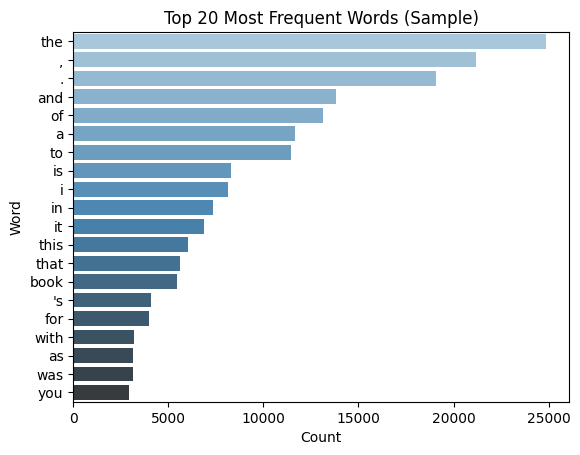

In [44]:
words = []
for review in sample_data['review/text'].dropna().astype(str):
    tokens = nltk.word_tokenize(review.lower())
    words.extend(tokens)

common = Counter(words).most_common(20)
word_df = pd.DataFrame(common, columns=['Word', 'Count'])

sns.barplot(x='Count', y='Word', data=word_df, palette='Blues_d')
plt.title("Top 20 Most Frequent Words (Sample)")
plt.show()


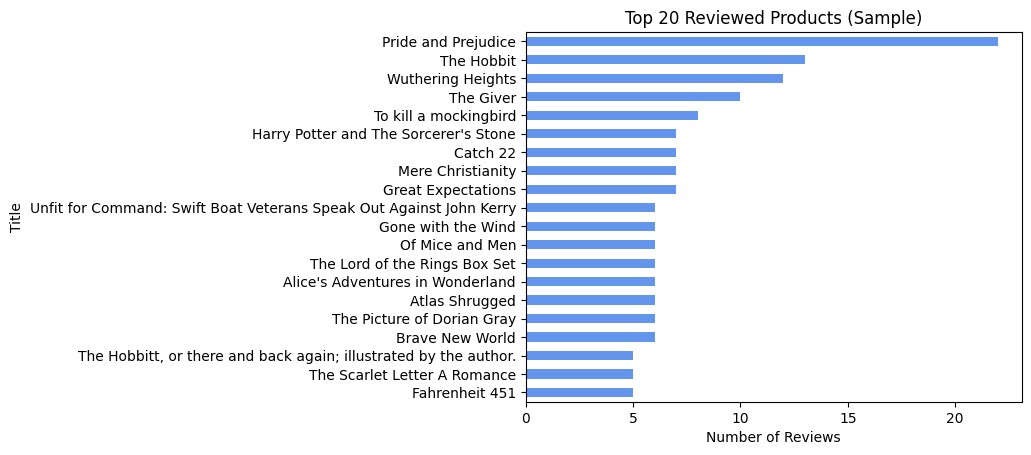

In [45]:
top_titles = sample_data['Title'].value_counts().head(20)

top_titles.plot(kind='barh', color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title("Top 20 Reviewed Products (Sample)")
plt.xlabel("Number of Reviews")
plt.show()


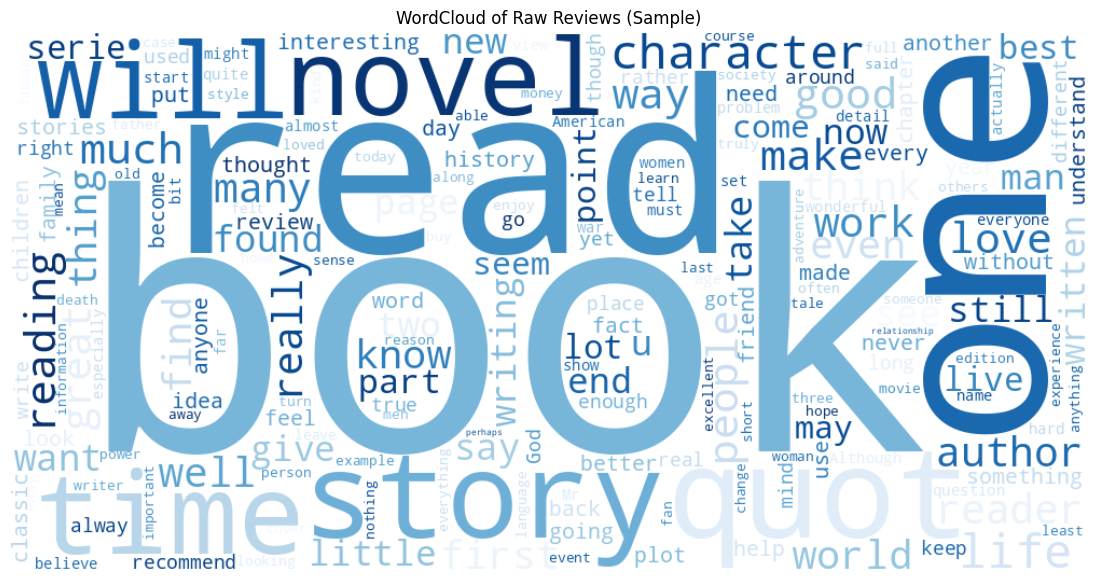

In [47]:
from wordcloud import WordCloud
text = " ".join(sample_data['review/text'].dropna().astype(str))
wc = WordCloud(width=1000, height=500, background_color='white', colormap='Blues').generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Raw Reviews (Sample)")
plt.show()




## 🔁 4. Sample the Data
We sample a subset of the data to:
- Speed up processing.
- Ensure we have a good mix of positive and negative samples.


In [49]:
# Take a larger sample to increase negative reviews
ratings_data = ratings_data.sample(n=20000, random_state=42)

## 🧰 5. Download Preprocessing Resources

In [50]:
# Text cleaning
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 🧹 6. Clean the Review Texts
Text cleaning involves:
- Lowercasing
- Removing punctuation and numbers
- Removing stopwords
- Filtering out short words


In [51]:
stop_words = set(stopwords.words('english'))

## 🧼 7. Apply Text Cleaning

In [52]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove short words
    return ' '.join(tokens)

## 🏷️ 8. Label the Reviews (Sentiment: Positive vs Negative)

In [53]:
# Apply cleaning to the review column (ensure column name is correct)
ratings_data['cleaned_review'] = ratings_data['review/text'].apply(clean_text)
# Create sentiment labels
def label_sentiment(score):
    return 'positive' if score > 3 else 'negative'

## 🧹 9. Drop Missing Data and Short Reviews

In [54]:
ratings_data['sentiment'] = ratings_data['review/score'].apply(label_sentiment)
ratings_data = ratings_data.dropna(subset=['cleaned_review', 'sentiment'])

## 📊 10. Sentiment Distribution (Before Oversampling)
This helps us understand the imbalance in the dataset.


In [55]:
# Filter out short texts (less than 3 words)
ratings_data = ratings_data[ratings_data['cleaned_review'].str.split().str.len() > 3]
# Check class distribution before oversampling
print("Class distribution before Oversampling:")
print(ratings_data['sentiment'].value_counts())
print("\nPercentage distribution:")
print(ratings_data['sentiment'].value_counts(normalize=True) * 100)

Class distribution before Oversampling:
sentiment
positive    15945
negative     4037
Name: count, dtype: int64

Percentage distribution:
sentiment
positive    79.796817
negative    20.203183
Name: proportion, dtype: float64


## 🔁 11. Visualize the distribution

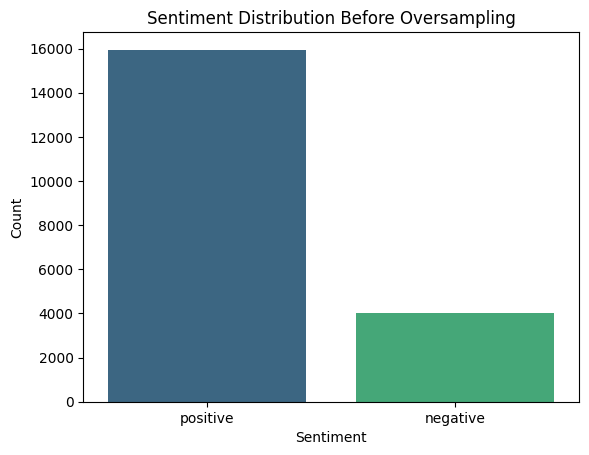

In [57]:
# Visualize the distribution
sns.countplot(x='sentiment', data=ratings_data, palette='viridis')
plt.title('Sentiment Distribution Before Oversampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## ⚖️ 12. Manual Oversampling
We duplicate the minority class to balance the dataset.


In [62]:
# Manual oversampling
positive = ratings_data[ratings_data['sentiment'] == 'positive']
negative = ratings_data[ratings_data['sentiment'] == 'negative']
negative_oversampled = resample(negative, replace=True, n_samples=len(positive), random_state=42)
balanced_data = pd.concat([positive, negative_oversampled])

In [63]:
# Check class distribution after oversampling
print("\nClass distribution after Oversampling:")
print(balanced_data['sentiment'].value_counts())


Class distribution after Oversampling:
sentiment
positive    15945
negative    15945
Name: count, dtype: int64


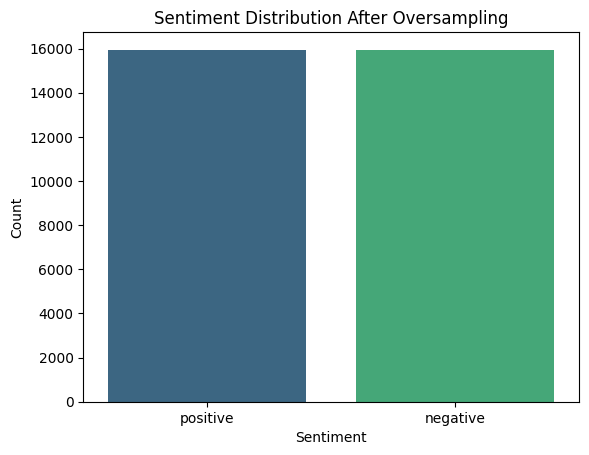

In [66]:
sns.countplot(x='sentiment', data=balanced_data, palette='viridis')
plt.title("Sentiment Distribution After Oversampling")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

## 🧠 13. TF-IDF Vectorization

In [13]:
# Prepare data
X = balanced_data['cleaned_review']
y = balanced_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Convert texts to TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## 📈 14. Model Evaluation

In [15]:
# Train the model
model = LogisticRegression(max_iter=1000, C=1.0)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [16]:
# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8584195672624647

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      3189
    positive       0.87      0.84      0.86      3189

    accuracy                           0.86      6378
   macro avg       0.86      0.86      0.86      6378
weighted avg       0.86      0.86      0.86      6378



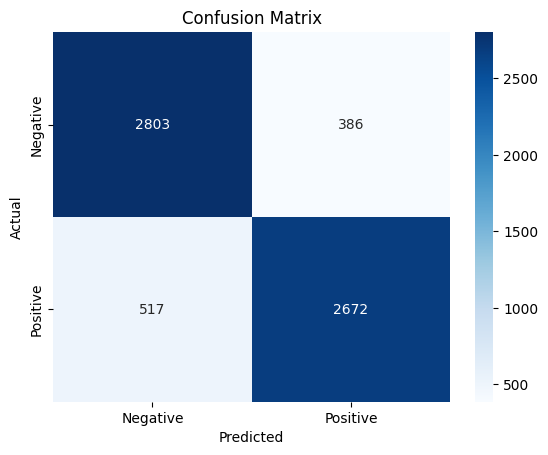

In [17]:
# Visualize confusion matrix
cm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
                 xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 📁 15. Show Saved Files

In [18]:
# Save the model and vectorizer
with open('/kaggle/working/sentiment_model_oversample.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('/kaggle/working/vectorizer_oversample.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
# Verify saved files
import os
print("Saved files:", os.listdir('/kaggle/working'))

Saved files: ['vectorizer_oversample.pkl', '.virtual_documents', 'sentiment_model_oversample.pkl']
